![DSME-logo](./static/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---
Notebook Authors: Paul Brunzema
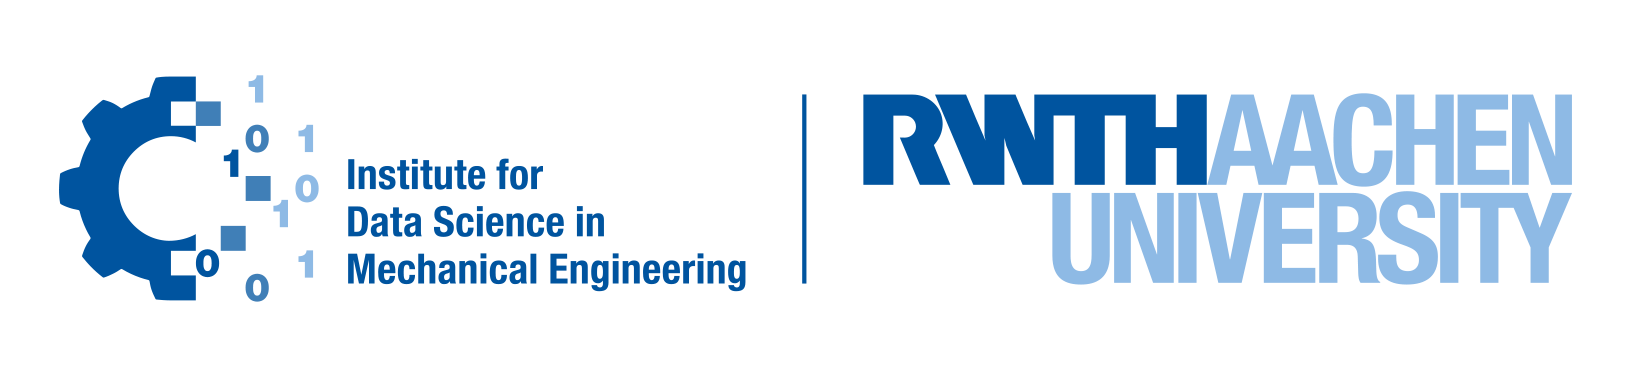

# LQR for the Cart Pole

In this notebook, we will design an LQR for stabilizing the upper equilibrium of the cart pole system.


In [1]:
import numpy as np

## The Cart Pole System

<center>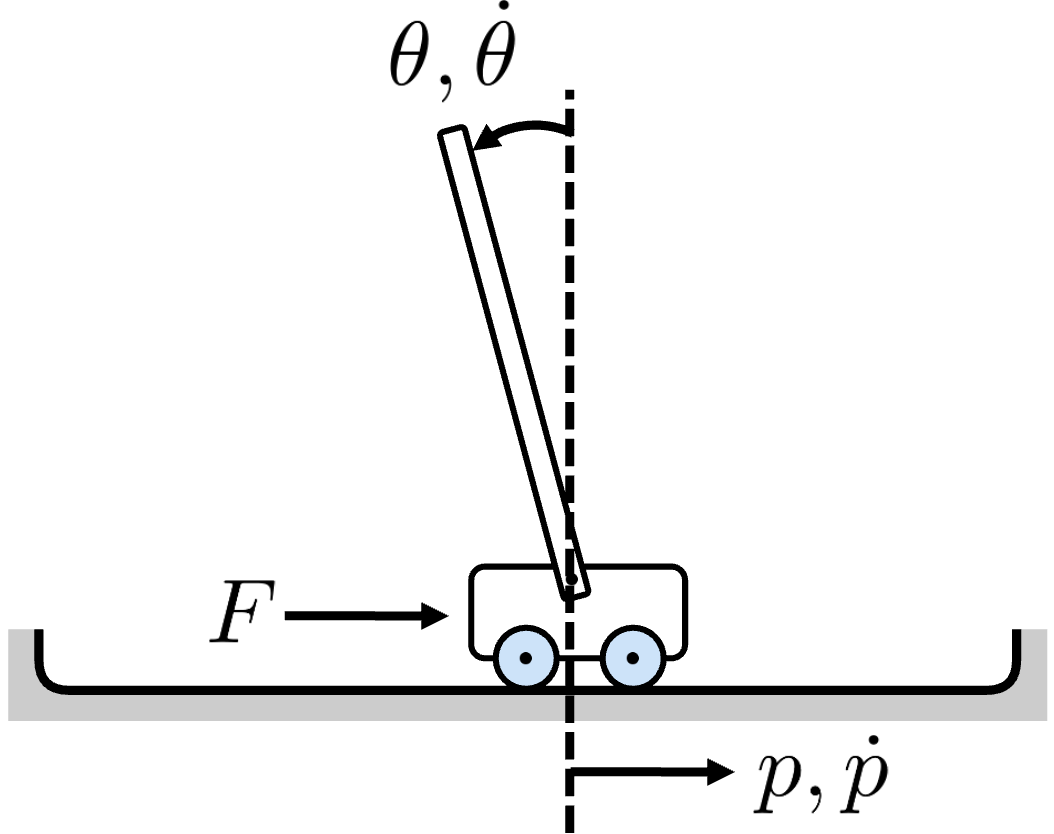</center>

A classic benchmark system in control and reinforcement learning

**States**

- position of the cart $p$
- angle of the pole $\theta$
- velocity of the cart $\dot p$ 
- angular velocity of the pole $\dot\theta$

**Input**

- Force applied to the cart $F$

In [2]:
# Example parameters
_DEFAULT_PARAMS = {
    "M": 1.0,  # Mass of cart (kg)
    "m": 0.1,  # Mass of pole (kg)
    "J": 0.01,  # Moment of inertia of pole (kg*m^2)
    "l": 0.5,  # Length to COM of pole (m)
    "c": 0.1,  # Cart friction coefficient
    "gamma": 0.01,  # Pole friction coefficient
    "g": 9.81,  # Gravity (m/s^2)
}


class CartPole:
    """
    Cart-pole system simulation model.

    This class implements a simulation of the inverted pendulum on a cart,
    with methods for dynamics, simulation, and visualization.
    """

    def __init__(self, params=False):
        """
        Initialize the cart-pole system with physical parameters.

        Args:
            params (dict): Parameters of the cart-pole system
        """
        self.params = {
            **_DEFAULT_PARAMS,
            **(params or {}),
        }

    def dynamics(self, t, state, u):
        """
        Compute the dynamics of the cart-pole system.

        Args:
            t (float): Time (not used in this system, but required for compatibility)
            state (numpy.ndarray): State vector [p, theta, dotp, theta_dot]
            u (float): Input force F

        Returns:
            numpy.ndarray: Time derivative of the state vector
        """
        # Extract state variables
        p, theta, p_dot, theta_dot = state

        # Extract parameters
        M = self.params["M"]  # Mass of the base (cart)
        m = self.params["m"]  # Mass of the pole
        J = self.params["J"]  # Moment of inertia of the pole
        l = self.params["l"]  # Distance from base to center of mass
        c = self.params["c"]  # Coefficient of viscous friction for cart
        gamma = self.params["gamma"]  # Coefficient of viscous friction for pole
        g = self.params["g"]  # Gravity acceleration

        # Compute total mass and total inertia
        Mt = M + m
        Jt = J + m * l**2

        # Compute sine and cosine of theta (using shorthand from equations)
        s_theta = np.sin(theta)
        c_theta = np.cos(theta)

        # First two state derivatives (directly from state definition)
        dp = p_dot
        dtheta = theta_dot

        # Third derivative (ddp) - cart acceleration
        numerator_p_ddot = (
            -m * l * s_theta * theta_dot**2
            + m * g * (m * l**2 / Jt) * s_theta * c_theta
            - c * p_dot
            - (gamma / Jt) * m * l * c_theta * theta_dot
            + u
        )
        denominator_p_ddot = Mt - m * (m * l**2 / Jt) * c_theta**2
        dp_dot = numerator_p_ddot / denominator_p_ddot

        # Fourth derivative (ddtheta) - pole angular acceleration
        numerator_theta_ddot = (
            -m * l**2 * s_theta * c_theta * theta_dot**2
            + Mt * g * l * s_theta
            - c * l * c_theta * p_dot
            - gamma * (Mt / m) * theta_dot
            + l * c_theta * u
        )
        denominator_theta_ddot = Jt * (Mt / m) - m * (l * c_theta) ** 2
        dtheta_dot = numerator_theta_ddot / denominator_theta_ddot

        # Combine into the derivative of the state vector
        dx = np.array([dp, dtheta, dp_dot, dtheta_dot])
        return dx

    def get_upper_linearized_dynamics(self):
        """
        Compute the linearized dynamics of the cart-pole system of the upper equilibrium point.

        Returns:
            tuple: A tuple containing:
                numpy.ndarray: A - State matrix
                numpy.ndarray: B - Input matrix
        """
        # Extract parameters
        M = self.params["M"]  # Mass of the base (cart)
        m = self.params["m"]  # Mass of the pole
        J = self.params["J"]  # Moment of inertia of the pole
        l = self.params["l"]  # Distance from base to center of mass
        c = self.params["c"]  # Coefficient of viscous friction for cart
        gamma = self.params["gamma"]  # Coefficient of viscous friction for pole
        g = self.params["g"]  # Gravity acceleration

        # Compute total mass and total inertia
        Mt = M + m
        Jt = J + m * l**2
        mu = Mt * Jt - m**2 * l**2

        # State matrix
        A = np.array(
            [
                [0, 0, 1, 0],
                [0, 0, 0, 1],
                [0, m**2 * l**2 * g / mu, -c * Jt / mu, -gamma * l * m / mu],
                [0, Mt * m * g * l / mu, -c * l * m / mu, -gamma * Mt / mu],
            ]
        )

        # Input matrix
        B = np.array([[0], [0], [Jt / mu], [l * m / mu]])
        return A, B

    def simulate(
        self,
        initial_state,
        controller=None,
        t_span=(0, 5),
        dt_sim=0.01,
        dt_control=0.02,
    ):
        """
        Simulate the system with a fixed control update frequency that potentially differs from simulation time step.

        Args:
            initial_state (array): Initial state [x, theta, x_dot, theta_dot]
            controller (function): Control law u = f(t, state)
            t_span (tuple): Time span (t_start, t_end)
            dt_sim (float): Simulation time step (for physics)
            dt_control (float): Control update interval (for controller)

        Returns:
            tuple: A tuple containing (time_array, state_array, control_array)
        """
        # Create time array for simulation
        t = np.arange(t_span[0], t_span[1], dt_sim)
        n_steps = len(t)

        # Initialize state and control arrays
        x = np.zeros((4, n_steps))
        u = np.zeros(n_steps)
        x[:, 0] = initial_state

        # Initialize control time and value
        next_control_time = t_span[0]
        current_control = 0.0

        # Function to compute state derivative with current control value
        def state_derivatives(t_current, state_current, control_current):
            return self.dynamics(t_current, state_current, control_current)

        # Simple fixed-step Runge-Kutta 4 integration
        for i in range(n_steps - 1):
            current_time = t[i]

            # Update control only at control frequency
            if current_time >= next_control_time:
                if controller is not None:
                    current_control = controller(current_time, x[:, i])
                else:
                    current_control = 0.0

                next_control_time = current_time + dt_control

            # Store the current control value
            u[i] = current_control

            # RK4 integration step (https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)
            k1 = state_derivatives(t[i], x[:, i], u[i])
            k2 = state_derivatives(t[i] + dt_sim / 2, x[:, i] + dt_sim / 2 * k1, u[i])
            k3 = state_derivatives(t[i] + dt_sim / 2, x[:, i] + dt_sim / 2 * k2, u[i])
            k4 = state_derivatives(t[i] + dt_sim, x[:, i] + dt_sim * k3, u[i])

            x[:, i + 1] = x[:, i] + dt_sim / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

        # Set the last control value
        if i + 1 < n_steps:
            u[i + 1] = current_control

        return t, x, u

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline


def plot_trajectories(time, states, controls):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)
    ax1.hlines(
        0, time[0], time[-1], linestyles="--", colors="gray", label="Equilibrium"
    )
    ax1.plot(time, states[0, :], label="Position", color="tab:blue", lw=2)
    ax1.plot(time, states[1, :], label="Angle", color="tab:red", lw=2)
    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Position [m], Angle [rad]")
    ax1.grid(True)
    ax1.legend()

    # plot control
    ax2.step(time, controls, label="Control", color="tab:orange", lw=2)
    ax2.set_ylabel("Control Force [N]")
    ax2.set_xlabel("Time [s]")
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

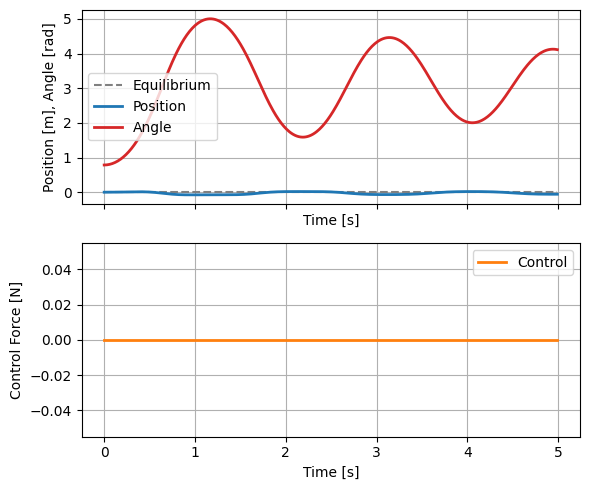

In [4]:
cart_pole = CartPole()
x0 = np.array([0.0, np.pi / 4, 0.0, 0.0])
t, x, u = cart_pole.simulate(x0)
plot_trajectories(t, x, u)

## For stability, we need a controller!

We will first specify an abstract controller whose interface has to be specified.


In [5]:
from abc import ABC, abstractmethod


class AbstractController(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def __call__(self, t, state):
        pass


class DummyController(AbstractController):
    def __init__(self, dummy_gain: float = 0.0):
        super().__init__()
        self.dummy_gain = dummy_gain

    def __call__(self, t, state):
        return self.dummy_gain

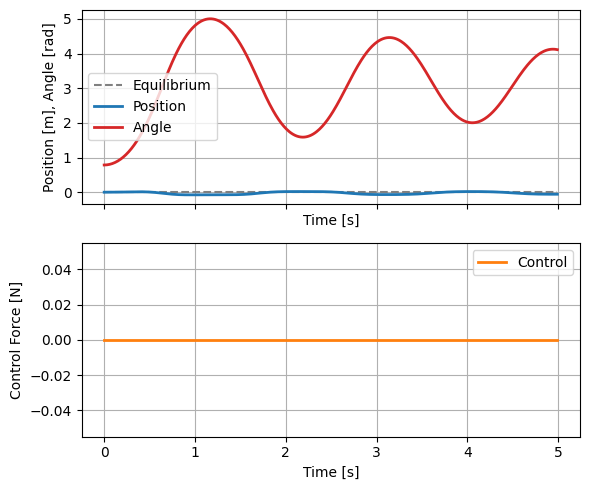

In [6]:
dummy_controller = DummyController()
t, x, u = cart_pole.simulate(x0, controller=dummy_controller)
plot_trajectories(t, x, u)

## Designing the LQR


In [7]:
dt = 0.02
A, B = cart_pole.get_upper_linearized_dynamics()
A_discrete = np.eye(4) + A * dt
B_discrete = B * dt
print(f"Eigenvalues of A: {np.linalg.eigvals(A_discrete)}")

Eigenvalues of A: [1.         0.91938963 1.07437293 0.99818189]


In [8]:
from scipy.linalg import solve_discrete_are


def compute_dlqr_gains(Ad, Bd, Q, R):
    P = solve_discrete_are(Ad, Bd, Q, R)
    K = np.linalg.inv(R + Bd.T @ P @ Bd) @ Bd.T @ P @ Ad
    return K


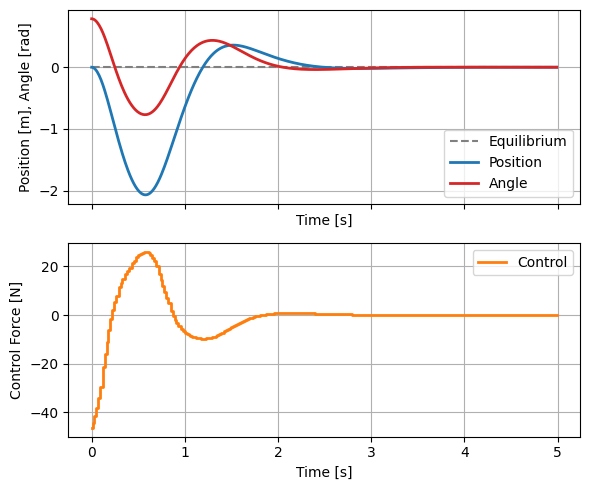

In [9]:
Q = np.diag([100.0, 1.0, 1.0, 1.0])
R = np.array([[1.]])

K_LQR = compute_dlqr_gains(A_discrete, B_discrete, Q, R)


class LinearFeedbackController(AbstractController):
    def __init__(self, K):
        super().__init__()
        self.K = K

    def __call__(self, t, state):
        u = -self.K @ state
        return u.item()


lqr_controller = LinearFeedbackController(K_LQR)
t, x, u = cart_pole.simulate(x0, controller=lqr_controller)
plot_trajectories(t, x, u)


In [10]:
print(f"Eigenvalues of A-BK: {np.linalg.eigvals(A_discrete - B_discrete @ K_LQR)}")

Eigenvalues of A-BK: [0.93633562+0.j         0.91156905+0.j         0.95631971+0.03924682j
 0.95631971-0.03924682j]


---
<center>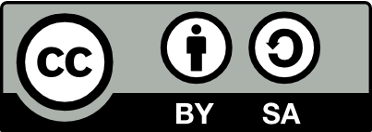</center>

This work was originally created by Sebastian Trimpe and Paul Brunzema. <br> 
It is licensed under Attribution-ShareAlike 4.0 International [(CC-BY-SA 4.0)](https://creativecommons.org/licenses/by-sa/4.0/).